# Probability Modelling in fmdtools
Here we will demonstrate the fmdkit's abilities to find a set of scenarios that represent the effects of a given mode.

In [1]:
#First, import the fault propogation library as well as the model
#since the package is in a parallel location to examples...
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import fmdtools.faultprop as fp
import fmdtools.resultproc as rp
import quadpy
from ex_pump import *
from IPython.display import HTML
mdl = Pump()

## Theory and Goals

The purpose of this document is to show the relative performance of various numerical integration techniques for resilience quantification.


### Some approaches:

- monte carlo with and without variance reduction

- quadrature (from quadpy)

- sample likeliest phase (`maxlike` option)


## Model Description
 pump: defined in ex_pump. Has the following functions:
 - import EE
 - import Water
 - import Signal
 - move Water
 - export Water
 
and flows:
- EE (to power the pump)
- Water_in
- Water_out
- Signal input (on/off)

(-1.3, 1.3)

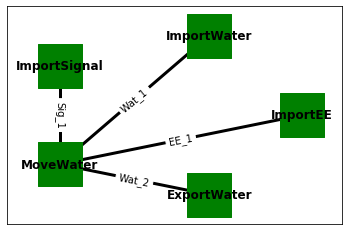

In [2]:
rp.show_graph(mdl.graph)
#plt.tight_layout(pad=-10)
plt.xlim([-1.2,1.3])
plt.ylim([-1.3,1.3])

In [3]:
endresults, resgraph, mdlhist=fp.run_one_fault(mdl, 'ExportWater', 'block', time=10, staged=True)
#rp.show_graph(resgraph)

The following shows the states of the system over time with and without a fault:

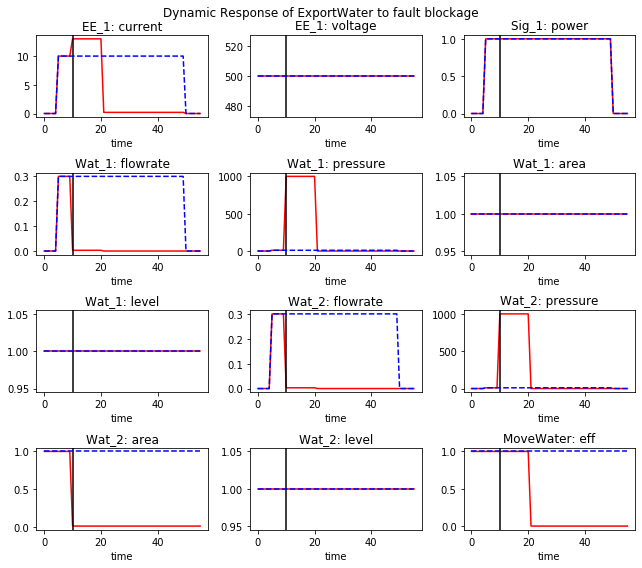

In [4]:
rp.plot_mdlhistvals(mdlhist, 'blockage', time=10, cols=3, legend=False)

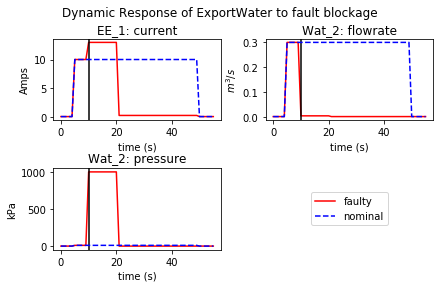

In [5]:
fig = rp.plot_mdlhistvals(mdlhist, 'blockage', time=10,fxnflowvals={'Wat_2':['flowrate', 'pressure'],'EE_1':'current'}, cols=2, returnfig=True, timelabel="time (s)")
fig.axes[0].set_ylabel("Amps")
fig.axes[1].set_ylabel("$m^3/s$")
fig.axes[2].set_ylabel("kPa")
fig.tight_layout(pad=0.3)
plt.subplots_adjust(top=0.93)
fig
fig.savefig("behaviorovertime.pdf", format="pdf")

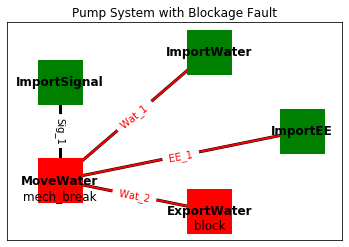

In [6]:
reshist,diff1, summary = rp.compare_hist(mdlhist)
fig, axis = rp.plot_resultsgraph_from(mdl, reshist, 45, scale=2.0, gtype='normal', retfig=True)
axis.set_xlim([-1.2,1.3])
axis.set_ylim([-1.3,1.3])
axis.set_title("Pump System with Blockage Fault")
fig.savefig("modelgraph.pdf", format="pdf")

Each of these flows also have different different costs associated with degraded performance:
 - repair cost
 - lost water cost
 - ee use cost
 These costs also have different forms. 

## Experiments

The goal of these experiments is to compare the error and efficiency of quadrature approaches at approximating the expected resilience over the simulation interval. 

### Introduce Quadratures
The quadratures used in this experiment are shown below. While quadpy has a few other quadratures that can be used, these were chosen becuase they take a single argument for the number of points used.

In [7]:
quadratures = {}

In [8]:
#quadratures['chebyshef-gauss 1'] = quadpy.line_segment.chebyshev_gauss_1 #argument is # of points
#quadratures['chebyshef-gauss 1'](3).show()

In [9]:
#quadratures['chebyshef-gauss 2'] = quadpy.line_segment.chebyshev_gauss_2 #argument is # of points
#quadratures['chebyshef-gauss 2'](3).show()

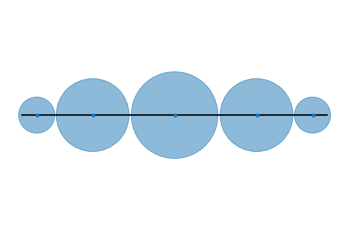

In [10]:
quadratures['gauss-legendre'] = quadpy.line_segment.gauss_legendre
quadratures['gauss-legendre'](5).show()
quadratures['gauss-legendre'](5).citation

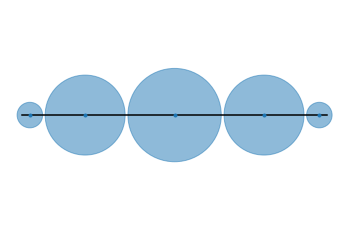

array([-9.51056516e-01, -5.87785252e-01, -6.12323400e-17,  5.87785252e-01,
        9.51056516e-01])

In [11]:
quadratures['fejer 1'] = quadpy.line_segment.fejer_1 #argument is # of points
quadratures['fejer 1'](5).show()
quadratures['fejer 1'](5).points

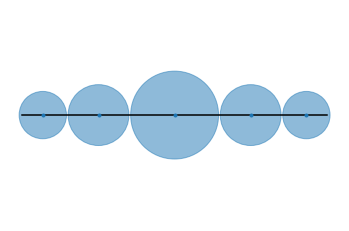

array([-8.66025404e-01, -5.00000000e-01, -6.12323400e-17,  5.00000000e-01,
        8.66025404e-01])

In [12]:
quadratures['fejer 2'] = quadpy.line_segment.fejer_2 #argument is # of points
quadratures['fejer 2'](5).show()
quadratures['fejer 2'](5).points

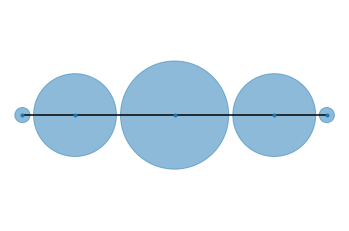

array([-1.00000000e+00, -6.54653671e-01,  6.66133815e-16,  6.54653671e-01,
        1.00000000e+00])

In [13]:
quadratures['gauss lobatto'] = quadpy.line_segment.gauss_lobatto #argument is # of points
quadratures['gauss lobatto'](5).show() 
(quadratures['gauss lobatto'](5).points)

In [14]:
#argument is number of pts, (optional) bias left, bias right (maybe try flipping?)
#quadratures['gauss radau'] = quadpy.line_segment.gauss_radau
#quadratures['gauss radau'](3).show()

In [15]:
#argument is n which makes the number of pts n+1
#quadratures['newton cotes closed'] = quadpy.line_segment.newton_cotes_closed 
#quadratures['newton cotes closed'](2).show()

In [16]:
#quadratures['newton cotes open'] = quadpy.line_segment.newton_cotes_open #argument num of pts
#quadratures['newton cotes open'](3).show() 

Some other possible quadratures are shown below. 

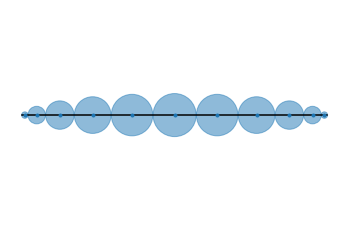

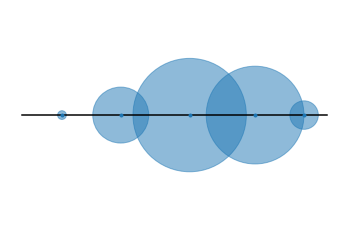

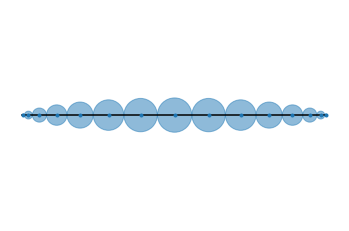

In [17]:
#Gauss-kronrod
quadpy.line_segment.gauss_kronrod(5).show() #argument is n which makes the number off pts 2*n+1
#Gauss-jacobi
quadpy.line_segment.gauss_jacobi(5, 1,2).show() #argument is # of points, left weighting, right weighting > -1
#Gauss-patterson
quadpy.line_segment.gauss_patterson(3).show() #argument is the order n, num pts is [1, 3, 7, 15, 31, 63, 127, 255 or 511]

The code below calculates the error of each approach over the number of points used. For the monte-carlo approaches, the results are averaged over 10 simulations and the standard deviation is provided for error bars. The computational cost is also determined by determined by taking the number of simulations needed for each (which is 1 per point (from simulating the nominal) and a fraction based on the injection time of the simulation (faults injected later take less time in simulation)).

### Experimental setup
The following function calculates the expected resilience of a model `mdl` (as well as a few other useful things) over the fault sampling approach defined in `approach`

In [18]:
def resilquant(approach, mdl):
    endclasses, mdlhists = fp.run_approach(mdl, approach)
    reshists, diffs, summaries = rp.compare_hists(mdlhists)
    
    fmea = rp.make_summfmea(endclasses, approach)
    fmea2 = rp.make_phasefmea(endclasses, approach)
    util=sum(fmea['expected cost'])
    expdegtimes = rp.make_expdegtimeheatmap(reshists, endclasses)
    return util, expdegtimes, fmea, fmea2

This experiment will test how well the quadratures approximate the expected costs of resilience by sampling different points in interval. This is done for the pump model introduced above using the blockage fault.

Below each of the cost types are shown:
 - repair costs (which is a step function due to the conditional fault that occurs due to delays)
 - water costs (which is linear due to the water lost at each timestep)
 - EE costs (which is constant and then exponentially decreasing due to the interval of adverse high current draw)
 - all costs together
 
 where the delay for degradation is 20 time-steps

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


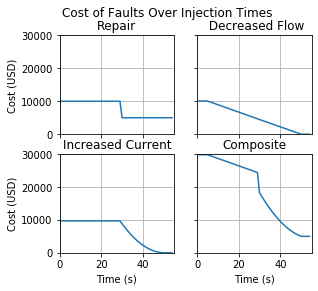

In [22]:
costs = [{'repair'}, {'water'}, {'ee'}, {'repair', 'water', 'ee'}]
costtitle={'repair':'Repair', 'water':' Decreased Flow', 'ee': 'Increased Current'}
costfig = plt.figure(figsize=(5,4))
costfig.add_subplot(2, 2, 4)
n=1
for cost in costs:
    mdl = Pump(params={'cost':cost, 'delay':20})
    app_full = SampleApproach(mdl, faults=[('ExportWater', 'block')], defaultsamp={'samp':'fullint'})
    endclasses, mdlhists = fp.run_approach(mdl, app_full)
    ax = costfig.add_subplot(2, 2, n)
    rp.plot_costovertime(endclasses, app_full, costtype='cost', timelabel='Time (s)')
    if len(cost)>1:
        plt.title("Composite")
    else:
        plt.title(costtitle[list(cost)[0]])
    plt.ylim([0,30000])
    plt.xlim(0,55)
    if n%2<1:
        ax.set_yticklabels([])
        ax.set_ylabel("")
    else:
        ax.set_ylabel("Cost (USD)")
    if n<3:
        ax.set_xticklabels([])
        ax.set_xlabel("")
    n+=1
costfig.suptitle("Cost of Faults Over Injection Times")
plt.subplots_adjust(left=0.2)
plt.savefig("costsovertime.pdf", format="pdf")

### Comparing Quadrature Error

The functions below compare the result from a set of sampling approaches with the full integral given that quadrature can use a certain amount of points to approximate the function. The error being used is absolute error.

In [23]:
def calcerror(fullutil, util):    
    return abs((fullutil-util)/(fullutil+0.000001))

In [24]:
def calc_errors(mdl, quadratures, possible_pts, util_full):
    errs = dict.fromkeys(quadratures)
    num_samps = dict.fromkeys(quadratures)
    for quadname, quad in quadratures.items():
        errs[quadname] = []
        num_samps[quadname] = []
        if quadname=='likeliest':
            app=SampleApproach(mdl,faults=[('ExportWater' ,'block')],defaultsamp={'samp':'likeliest'})
            util, expdegtimes, fmea, phasefmea = resilquant(app, mdl)
            errs[quadname] = errs[quadname] + [calcerror(util_full, util)]
            num_samps[quadname] = num_samps[quadname] + [len(app.times) + sum([(55-scen['properties']['time'])/55 for scen in app.scenlist])]
        else:
            for pt in possible_pts:
                try:
                    if quadname == 'evenspacing': app=SampleApproach(mdl,faults=[('ExportWater' ,'block')],defaultsamp={'samp':'evenspacing','numpts':pt})
                    else:  app=SampleApproach(mdl,faults=[('ExportWater' ,'block')],defaultsamp={'samp':'quadrature','quad':quad(pt)})
                    util, expdegtimes, fmea, phasefmea = resilquant(app, mdl)
                    errs[quadname] = errs[quadname] + [calcerror(util_full, util)]
                    num_samps[quadname] = num_samps[quadname] + [len(app.times) + sum([(55-scen['properties']['time'])/55 for scen in app.scenlist])]
                except: 0
    return errs, num_samps

Paremeters for the experiment:

In [25]:
possible_pts = range(1,15) # points for the quadrature
#quadratures['evenspacing'] = 1   # adding evenly spaced sampling 
#quadratures['likeliest'] = 1     # adding likeliest phase sampling
delaytimes = [12, 23, 34]        # delay times to test

Calculating the error over each cost type, delay, and number of points

In [26]:
errovercosts=dict()
for cost in costs:
    errovercosts[str(cost)]=dict()
    for delay in delaytimes:
        n+=1
        mdl = Pump(params={'cost':cost, 'delay':delay})
        app_full = SampleApproach(mdl, faults=[('ExportWater', 'block')], defaultsamp={'samp':'fullint'})
        util_full, expdegtimes_full, fmea_full, phasefmea_full = resilquant(app_full, mdl)
        errovercosts[str(cost),delay], num_samps = calc_errors(mdl, quadratures, possible_pts, util_full)

Plotting results:

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


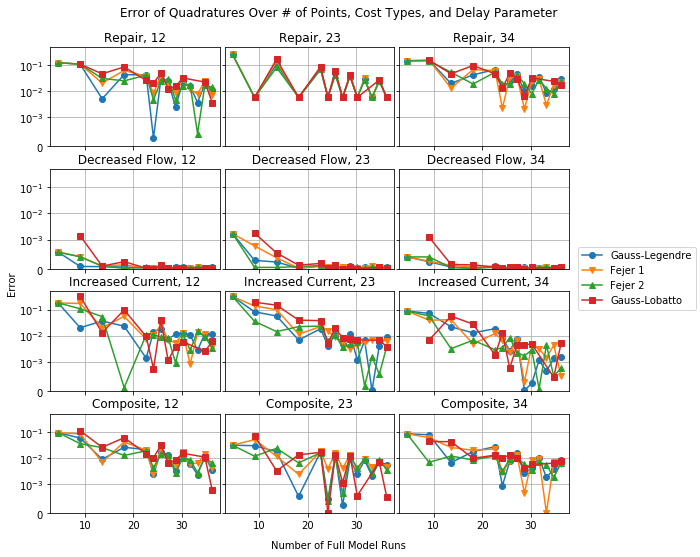

In [43]:
figure = plt.figure(figsize=(10, 8))
figure.add_subplot(len(costs), len(delaytimes), len(costs)*len(delaytimes))
n=0
markers = {"gauss-legendre":"o","fejer 1":"v", "fejer 2":"^", "gauss lobatto":"s"}
labs = {"gauss-legendre":"Gauss-Legendre","fejer 1":"Fejer 1", "fejer 2":"Fejer 2", "gauss lobatto":"Gauss-Lobatto"}
for cost in costs:
    for delay in delaytimes:
        n+=1
        ax = figure.add_subplot(len(costs), len(delaytimes), n)
        for quad in errovercosts[str(cost), delay]:
            ax.plot(num_samps[quad], errovercosts[str(cost), delay][quad], marker=markers[quad], label=labs[quad])#, label=labels[quad], marker=markers[quad])
        title = list(cost)
        if len(title)>1: title="Composite"
        else: title = costtitle[list(cost)[0]]
        ax.set_title(title+", "+str(delay))
        ax.set_yscale("symlog", linthreshy=0.001)
        ax.set_ylim([0,0.5])
        ax.grid(True)
        if delay != min(delaytimes): ax.set_yticklabels([])
        if title != "Composite": ax.set_xticklabels([])
        handles, labels = ax.get_legend_handles_labels()
figure.suptitle("Error of Quadratures Over # of Points, Cost Types, and Delay Parameter")
figure.legend(handles, labels, loc="center right") #bbox_to_anchor=(1.1, 0.5))
figure.text(0.5, 0.04, 'Number of Full Model Runs', ha='center')
figure.text(0.04, 0.5, 'Error', va='center', rotation='vertical')

figure.tight_layout(pad=0.3)
plt.subplots_adjust(right=0.82, left=0.1, top=0.91, bottom=0.1)

plt.savefig("quad_errors.pdf", format="pdf")

In [44]:
avg_cost=pd.DataFrame()
for cost in costs:
    for delay in delaytimes:
        ed=errovercosts[str(cost), delay]
        df_cost = pd.DataFrame.from_dict(dict([(k,pd.Series(v)) for k,v in ed.items()]))
        df_cost["gauss lobatto"]=df_cost["gauss lobatto"].shift(1)
        avg_cost[str(cost),delay]=df_cost[1:11].mean()
avg_cost = avg_cost.transpose()
avg_cost

,gauss-legendre,fejer 1,fejer 2,gauss lobatto
"({'repair'}, 12)",0.028981,0.033825,0.030052,0.041259
"({'repair'}, 23)",0.032055,0.036366,0.028297,0.040804
"({'repair'}, 34)",0.042202,0.041851,0.040362,0.049159
"({'water'}, 12)",0.000047,0.000085,0.000070,0.000196
"({'water'}, 23)",0.000087,0.000152,0.000045,0.000282
"({'water'}, 34)",0.000058,0.000068,0.000060,0.000176
"({'ee'}, 12)",0.015633,0.031434,0.021652,0.049239
"({'ee'}, 23)",0.020304,0.031134,0.012642,0.046851
"({'ee'}, 34)",0.014471,0.012037,0.008859,0.012037
"({'repair', 'water', 'ee'}, 12)",0.016969,0.021309,0.014477,0.029178


In [45]:
averages = pd.DataFrame([avg_cost[0:3].mean(),avg_cost[3:6].mean() ,avg_cost[6:9].mean(), avg_cost[9:12].mean(), avg_cost.mean()])
averages["names"]=["repair", "water", "ee", "composite", "average"]
averages= averages[["names", "gauss-legendre", "fejer 1", "fejer 2", "gauss lobatto"]]
averages

,names,gauss-legendre,fejer 1,fejer 2,gauss lobatto
0,repair,0.034412,0.037347,0.032904,0.043741
1,water,0.000064,0.000102,0.000058,0.000218
2,ee,0.016802,0.024868,0.014384,0.036042
3,composite,0.014566,0.017100,0.010562,0.019561
4,average,0.016461,0.019855,0.014477,0.024891


In [46]:
averages.to_latex()

'\\begin{tabular}{llrrrr}\n\\toprule\n{} &      names &  gauss-legendre &   fejer 1 &   fejer 2 &  gauss lobatto \\\\\n\\midrule\n0 &     repair &        0.034412 &  0.037347 &  0.032904 &       0.043741 \\\\\n1 &      water &        0.000064 &  0.000102 &  0.000058 &       0.000218 \\\\\n2 &         ee &        0.016802 &  0.024868 &  0.014384 &       0.036042 \\\\\n3 &  composite &        0.014566 &  0.017100 &  0.010562 &       0.019561 \\\\\n4 &    average &        0.016461 &  0.019855 &  0.014477 &       0.024891 \\\\\n\\bottomrule\n\\end{tabular}\n'

If individual plots are desired:

In [47]:
def plot_errors(errs, num_samps, showlegend=True):
    for quad in errs:
        plt.plot(num_samps[quad], errs[quad], label=quad, marker='o')
    if showlegend: plt.legend(loc='upper right')
    plt.xlabel("Number of Full Model Runs")
    plt.yscale("symlog", linthreshy=0.001)
    plt.grid('both')
    plt.ylabel("Percent Error")

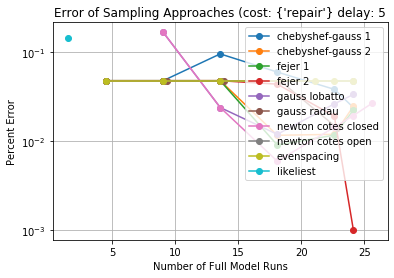

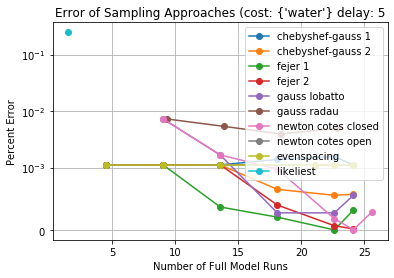

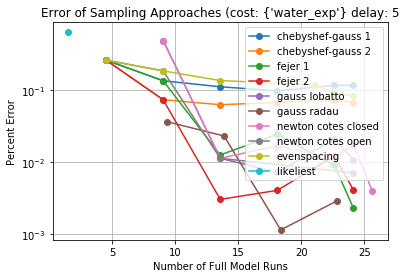

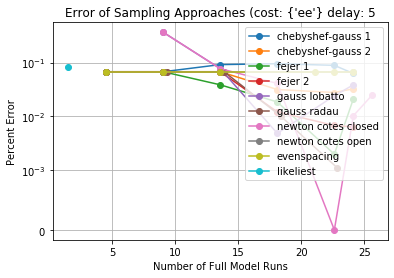

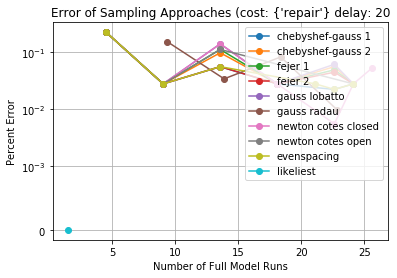

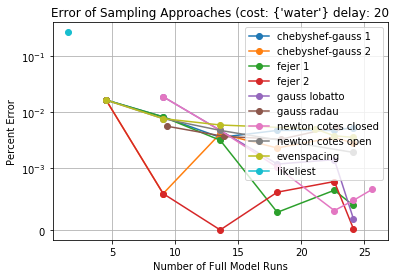

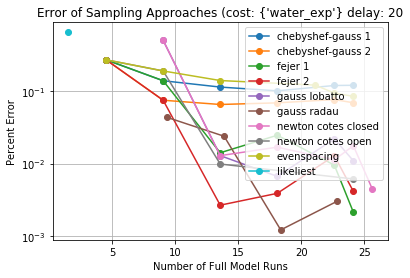

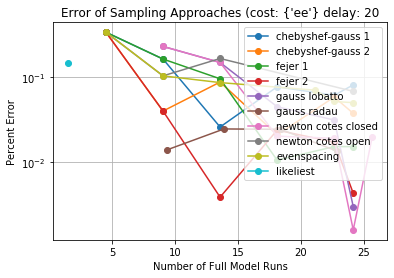

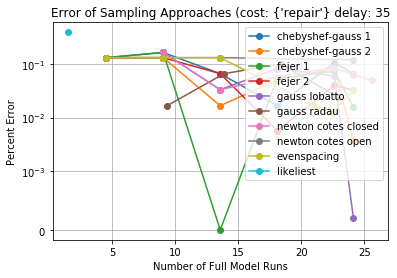

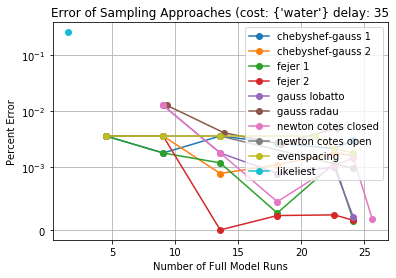

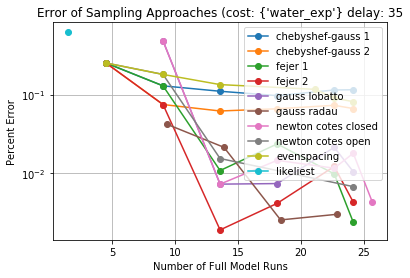

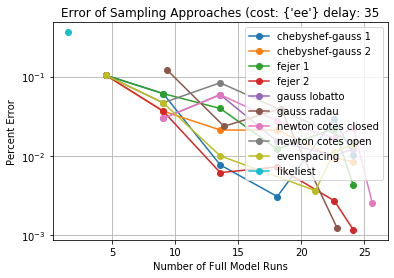

In [26]:
for delay in delaytimes:
    for cost in costs:
        mdl = Pump(params={'cost':cost, 'delay':delay})
        app_full = SampleApproach(mdl, faults=[('ExportWater', 'block')], defaultsamp={'samp':'fullint'})
        util_full, expdegtimes_full, fmea_full, phasefmea_full = resilquant(app_full, mdl)
        errs, num_samps = calc_errors(mdl, quadratures, possible_pts, util_full)
        plt.figure()
        plt.title("Error of Sampling Approaches (cost: "+str(cost)+" delay: "+str(delay))
        plot_errors(errs, num_samps)

What if the form of the integral was known beforehand? In that case one would be interested in knowing the points that best represente the space for future iteration. There are two options for that in this model: 'single-point' and 'piecewise'

In [48]:
mdl = Pump(params={'cost':{'water', 'repair', 'ee'}, 'delay':10})
app_full = SampleApproach(mdl, faults=[('ExportWater', 'block')], defaultsamp={'samp':'fullint'})
app_piecewise = SampleApproach(mdl, faults=[('ExportWater', 'block')], defaultsamp={'samp':'fullint'})
app_bestpt = SampleApproach(mdl, faults=[('ExportWater', 'block')], defaultsamp={'samp':'fullint'})
endclasses, mdlhists = fp.run_approach(mdl, app_full)
app_piecewise.prune_scenarios(endclasses, samptype='piecewise')
app_bestpt.prune_scenarios(endclasses, samptype='bestpt')

delaytimes = [i for i in range(0,45,1)]
piecewiseerr=[]
bestpterr=[]
for delay in delaytimes:
    mdl = Pump(params={'cost':{'water', 'repair', 'ee'}, 'delay':delay}) 
    util_full, expdegtimes_full, fmea_full, phasefmea_full = resilquant(app_full, mdl)
    util_piecewise, expdegtimes_piecewise, fmea_piecewise, phasefmea_piecewise = resilquant(app_piecewise, mdl)
    util_bestpt, expdegtimes_bestpt, fmea_bestpt, phasefmea_bestpt = resilquant(app_bestpt, mdl)
    piecewiseerr=piecewiseerr+[calcerror(util_full, util_piecewise)]
    bestpterr = bestpterr +[calcerror(util_full, util_bestpt)]


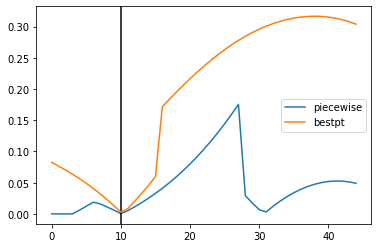

In [49]:
plt.figure()
plt.plot(delaytimes, piecewiseerr, label='piecewise')
plt.axvline(10, color='black')
plt.plot(delaytimes, bestpterr, label='bestpt')
plt.legend()

This may change over the delay time parameters chosen. The code below plots the value over a set of possible delay paremeters.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


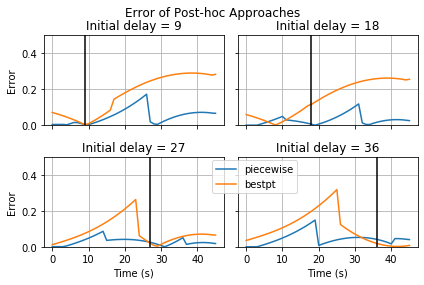

In [69]:
postplot = plt.figure()
postplot.add_subplot(2,2,4)
n=0
for initdelay in [9,18,27,36]:
    n+=1
    mdl = Pump(params={'cost':{'water', 'repair', 'ee'}, 'delay':initdelay})
    app_full = SampleApproach(mdl, faults=[('ExportWater', 'block')], defaultsamp={'samp':'fullint'})
    app_piecewise = SampleApproach(mdl, faults=[('ExportWater', 'block')], defaultsamp={'samp':'fullint'})
    app_bestpt = SampleApproach(mdl, faults=[('ExportWater', 'block')], defaultsamp={'samp':'fullint'})
    endclasses, mdlhists = fp.run_approach(mdl, app_full)
    app_piecewise.prune_scenarios(endclasses, samptype='piecewise')
    app_bestpt.prune_scenarios(endclasses, samptype='bestpt')

    delays = [i for i in range(0,46,1)]
    piecewiseerr=[]
    bestpterr=[]
    for delay in delays:
        mdl = Pump(params={'cost':{'water', 'repair', 'ee'}, 'delay':delay}) 
        util_full, expdegtimes_full, fmea_full, phasefmea_full = resilquant(app_full, mdl)
        util_piecewise, expdegtimes_piecewise, fmea_piecewise, phasefmea_piecewise = resilquant(app_piecewise, mdl)
        util_bestpt, expdegtimes_bestpt, fmea_bestpt, phasefmea_bestpt = resilquant(app_bestpt, mdl)
        piecewiseerr=piecewiseerr+[calcerror(util_full, util_piecewise)]
        bestpterr = bestpterr +[calcerror(util_full, util_bestpt)]
    
    ax = postplot.add_subplot(2,2,n)
    plt.ylim([0,0.5])
    plt.plot(delays, piecewiseerr, label='piecewise')
    plt.plot(delays, bestpterr, label='bestpt')
    handles, labels = ax.get_legend_handles_labels()
    plt.axvline(initdelay, color='black', label = 'init. delay')
    plt.title("Initial delay = "+str(initdelay))
    plt.grid()
    if n%2<1:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel("Error")
    if n<3:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("Time (s)")
postplot.suptitle("Error of Post-hoc Approaches")
postplot.tight_layout()
postplot.subplots_adjust(top=0.88)
postplot.legend(handles, labels, bbox_to_anchor=(0.7, 0.45))
postplot.savefig("posthoc_err.pdf", format="pdf")

In [70]:
app_full = SampleApproach(mdl, faults=[('ExportWater', 'block')], defaultsamp={'samp':'fullint'})
util_full, expdegtimes_full, fmea_full, phasefmea_full = resilquant(app_full, mdl)

In [71]:
possible_pts=range(1,45)
samp_types = ['evenspacing', 'randtimes', 'symrandtimes', 'quadrature']
errs=dict.fromkeys(samp_types)
errbars=dict.fromkeys(samp_types)
errbar_samps = dict.fromkeys(samp_types)
num_samples = dict.fromkeys(samp_types)
ave_pts=20

util_full, expdegtimes_full, fmea_full, phasefmea_full = resilquant(app_full, mdl)
for samp_type in samp_types:
    errs[samp_type]=[]
    errbars[samp_type]=[]
    num_samples[samp_type]=[]
    errbar_samps[samp_type] = []
    for pt in possible_pts: #calc errors
        if samp_type in ['randtimes', 'arandtimes', 'symrandtimes']:
            samperrs=[]
            samps = []
            for ave_pt in range(ave_pts):
                app=SampleApproach(mdl, faults=[('ExportWater', 'block')], defaultsamp={'samp':samp_type, 'numpts':pt})
                util, expdegtimes, fmea, phasefmea = resilquant(app, mdl)
                samperrs=samperrs+[calcerror(util_full, util)]
                samps = samps + [len(app.times) + sum([(55-scen['properties']['time'])/55 for scen in app.scenlist])]
            err=np.mean(samperrs)
            errbar=np.std(samperrs)
            num_samps= np.mean(samps)
            errbar_samp = np.std(samps)
        elif samp_type=='quadrature':
            try:
                quadrature = quadpy.line_segment.gauss_legendre(pt)
                app=SampleApproach(mdl, faults=[('ExportWater', 'block')], defaultsamp={'samp':'quadrature', 'quad':quadrature})
                util, expdegtimes, fmea, phasefmea = resilquant(app, mdl)
                err = calcerror(util_full, util)
                errbar=0.0
                num_samps = len(app.times) + sum([(55-scen['properties']['time'])/55 for scen in app.scenlist])
                errbar_samp = 0.0
            except:
                0
        else:
            app=SampleApproach(mdl, faults=[('ExportWater', 'block')], defaultsamp={'samp':samp_type, 'numpts':pt})
            util, expdegtimes, fmea, phasefmea = resilquant(app, mdl)
            err = calcerror(util_full, util)
            errbar=0.0
            num_samps = len(app.times) + sum([(55-scen['properties']['time'])/55 for scen in app.scenlist])
            errbar_samp = 0.0
        errs[samp_type]=errs[samp_type]+[err]
        errbars[samp_type]=errbars[samp_type]+[errbar]
        num_samples[samp_type] = num_samples[samp_type] + [num_samps]
        errbar_samps[samp_type] = errbar_samps[samp_type] + [errbar_samp]


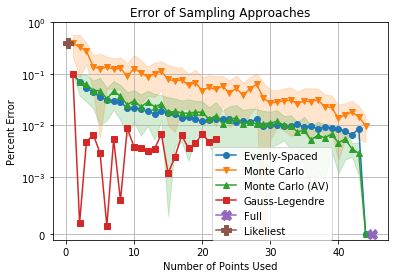

In [84]:
fig=plt.figure(figsize=(6,4))
errbar_samps['full'] = [0.0]
errs['full']=[0.0]
errbars['full']=[0.0]
num_samples['full'] = [len(app_full.times) + sum([(55-scen['properties']['time'])/55 for scen in app_full.scenlist])]


app_maxlike = SampleApproach(mdl, faults=[('ExportWater', 'block')], defaultsamp={'samp':'likeliest'})
util_maxlike, expdegtimes_maxlike, fmea_maxlike, phasefmea_maxlike = resilquant(app_maxlike, mdl)
errbar_samps['likeliest'] = [0.0]
errs['likeliest']=[calcerror(util_full, util_maxlike)]
errbars['likeliest']=[0.0]
num_samples['likeliest'] = [len(app_maxlike.times) + sum([(55-scen['properties']['time'])/55 for scen in app_maxlike.scenlist])]


markers = {"evenspacing":"o", "randtimes":"v", "symrandtimes":"^", "full":"X", "likeliest":"P", "quadrature":"s"}
labels = {"evenspacing":"Evenly-Spaced", "randtimes":"Monte Carlo", "symrandtimes":"Monte Carlo (AV)", "full":"Full", "likeliest":"Likeliest", "quadrature":"Gauss-Legendre"}
#for samp in num_samples:
#    plt.errorbar(num_samples[samp], errs[samp], yerr=errbars[samp],marker = markers[samp], label=samp)
for samp in num_samples:
    if samp in ["evenspacing", "randtimes", "symrandtimes", "quadrature"]:
        if samp=="quadrature":
            p = plt.plot(possible_pts[0:22], errs[samp][0:22],marker = markers[samp], label=labels[samp])
        else:
            p = plt.plot(possible_pts, errs[samp],marker = markers[samp], label=labels[samp])
        if samp in ["symrandtimes", "randtimes"]:
            errline=np.array(errs[samp])
            bars=np.array(errbars[samp])
            plt.fill_between(possible_pts,errline+bars,errline-bars, alpha=0.2,color=p[0].get_color())
    elif samp=="likeliest":
        plt.errorbar(0.3, errs[samp], yerr=errbars[samp],marker = markers[samp], label=labels[samp], markersize=10)
    elif samp=="full":
        plt.errorbar(45, errs[samp], yerr=errbars[samp],marker = markers[samp], label=labels[samp], markersize=10)

#plt.errorbar(range(len(num_samps)), list(num_samps.values(), )
#plt.xticks(range(len(num_samps)), list(num_samps.keys())
plt.legend(loc='upper right',bbox_to_anchor=(0.35, 0., 0.5, 0.45))
plt.xlabel("Number of Points Used")
plt.yscale("symlog", linthreshy=0.001)
plt.ylim([-0.0001,1])
#plt.xscale("log")
plt.grid('both')
plt.ylabel("Percent Error")
plt.title("Error of Sampling Approaches")

plt.savefig("hl_error.pdf", format="pdf")

In [69]:
avgoverallerr = {k: np.mean(v) for k,v in errs.items()}

In [70]:
avgoverallerr

{'evenspacing': 0.019018908586354414,
 'randtimes': 0.07420160329820616,
 'symrandtimes': 0.020129686550137135,
 'quadrature': 0.006972461032669016,
 'full': 0.0,
 'likeliest': 0.38936521630708215}